<a href="https://colab.research.google.com/github/samswede/Font-Recommender/blob/main/VAE_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars
import plotly.io as pio

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE
import plotly.express as px

In [2]:
data_dir = 'dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



In [22]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform

In [23]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [24]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [25]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [26]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss

In [27]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [28]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [29]:
### Testing function
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            # Move tensor to the proper device
            x = x.to(device)
            # Encode data
            encoded_data = vae.encoder(x)
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [30]:
def plot_ae_outputs(encoder,decoder,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         rec_img  = decoder(encoder(img))
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)  
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()   

	 partial train loss (single batch): 69409.125000
	 partial train loss (single batch): 67753.453125
	 partial train loss (single batch): 65867.375000
	 partial train loss (single batch): 64897.050781
	 partial train loss (single batch): 63299.683594
	 partial train loss (single batch): 62252.781250
	 partial train loss (single batch): 61348.898438
	 partial train loss (single batch): 60598.738281
	 partial train loss (single batch): 59983.171875
	 partial train loss (single batch): 59055.160156
	 partial train loss (single batch): 58873.847656
	 partial train loss (single batch): 58053.894531
	 partial train loss (single batch): 57743.226562
	 partial train loss (single batch): 57420.945312
	 partial train loss (single batch): 56708.136719
	 partial train loss (single batch): 56333.359375
	 partial train loss (single batch): 56183.730469
	 partial train loss (single batch): 55485.562500
	 partial train loss (single batch): 55225.210938
	 partial train loss (single batch): 54593.550781


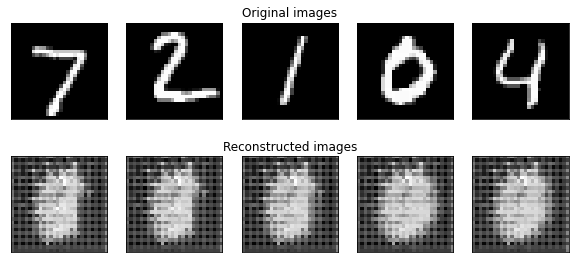

	 partial train loss (single batch): 19902.296875
	 partial train loss (single batch): 19616.388672
	 partial train loss (single batch): 19933.302734
	 partial train loss (single batch): 19671.498047
	 partial train loss (single batch): 19517.281250
	 partial train loss (single batch): 19481.267578
	 partial train loss (single batch): 19535.960938
	 partial train loss (single batch): 19404.287109
	 partial train loss (single batch): 19430.521484
	 partial train loss (single batch): 19373.601562
	 partial train loss (single batch): 19137.320312
	 partial train loss (single batch): 19281.748047
	 partial train loss (single batch): 18929.501953
	 partial train loss (single batch): 18926.691406
	 partial train loss (single batch): 18959.523438
	 partial train loss (single batch): 18868.580078
	 partial train loss (single batch): 18839.785156
	 partial train loss (single batch): 18972.464844
	 partial train loss (single batch): 18542.808594
	 partial train loss (single batch): 18590.753906


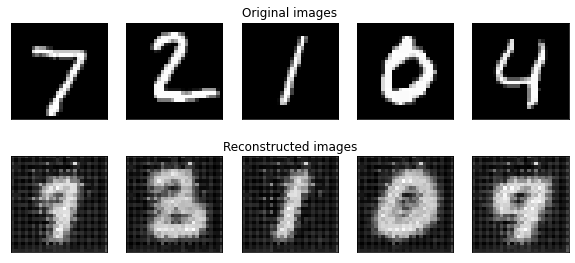

	 partial train loss (single batch): 13126.617188
	 partial train loss (single batch): 13072.269531
	 partial train loss (single batch): 13545.341797
	 partial train loss (single batch): 13085.852539
	 partial train loss (single batch): 13142.248047
	 partial train loss (single batch): 13062.961914
	 partial train loss (single batch): 13078.065430
	 partial train loss (single batch): 13091.484375
	 partial train loss (single batch): 13158.223633
	 partial train loss (single batch): 13250.907227
	 partial train loss (single batch): 12870.227539
	 partial train loss (single batch): 13190.770508
	 partial train loss (single batch): 12876.777344
	 partial train loss (single batch): 12827.295898
	 partial train loss (single batch): 13025.822266
	 partial train loss (single batch): 12817.825195
	 partial train loss (single batch): 12893.389648
	 partial train loss (single batch): 13036.087891
	 partial train loss (single batch): 12712.580078
	 partial train loss (single batch): 12878.307617


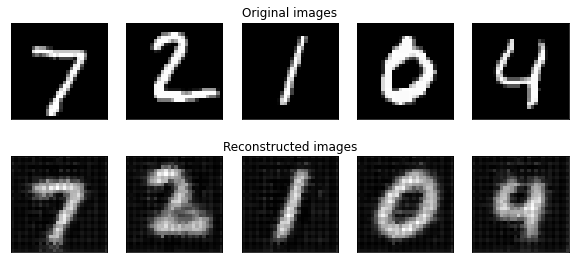

	 partial train loss (single batch): 10599.995117
	 partial train loss (single batch): 10749.179688
	 partial train loss (single batch): 11058.481445
	 partial train loss (single batch): 10611.832031
	 partial train loss (single batch): 10597.856445
	 partial train loss (single batch): 10533.814453
	 partial train loss (single batch): 10641.921875
	 partial train loss (single batch): 10641.703125
	 partial train loss (single batch): 10782.876953
	 partial train loss (single batch): 10719.125000
	 partial train loss (single batch): 10373.494141
	 partial train loss (single batch): 10776.689453
	 partial train loss (single batch): 10553.024414
	 partial train loss (single batch): 10465.465820
	 partial train loss (single batch): 10852.918945
	 partial train loss (single batch): 10442.229492
	 partial train loss (single batch): 10536.193359
	 partial train loss (single batch): 10708.976562
	 partial train loss (single batch): 10344.066406
	 partial train loss (single batch): 10311.792969


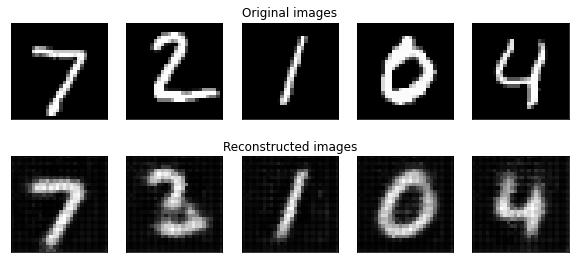

	 partial train loss (single batch): 9643.868164
	 partial train loss (single batch): 9778.695312
	 partial train loss (single batch): 10025.769531
	 partial train loss (single batch): 9681.939453
	 partial train loss (single batch): 9631.666016
	 partial train loss (single batch): 9580.787109
	 partial train loss (single batch): 9672.996094
	 partial train loss (single batch): 9634.140625
	 partial train loss (single batch): 9953.247070
	 partial train loss (single batch): 9764.372070
	 partial train loss (single batch): 9295.958984
	 partial train loss (single batch): 9855.664062
	 partial train loss (single batch): 9764.005859
	 partial train loss (single batch): 9593.881836
	 partial train loss (single batch): 9959.843750
	 partial train loss (single batch): 9609.589844
	 partial train loss (single batch): 9744.050781
	 partial train loss (single batch): 9860.333008
	 partial train loss (single batch): 9540.300781
	 partial train loss (single batch): 9438.513672
	 partial train los

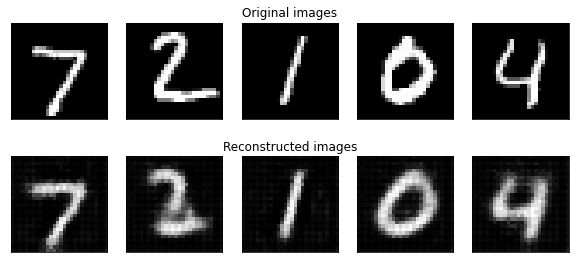

	 partial train loss (single batch): 9254.467773
	 partial train loss (single batch): 9300.339844
	 partial train loss (single batch): 9667.244141
	 partial train loss (single batch): 9294.917969
	 partial train loss (single batch): 9241.224609
	 partial train loss (single batch): 9102.635742
	 partial train loss (single batch): 9319.958984
	 partial train loss (single batch): 9177.546875
	 partial train loss (single batch): 9601.245117
	 partial train loss (single batch): 9287.883789
	 partial train loss (single batch): 9027.064453
	 partial train loss (single batch): 9481.939453
	 partial train loss (single batch): 9302.686523
	 partial train loss (single batch): 9197.103516
	 partial train loss (single batch): 9600.703125
	 partial train loss (single batch): 9217.050781
	 partial train loss (single batch): 9384.520508
	 partial train loss (single batch): 9525.333984
	 partial train loss (single batch): 9063.927734
	 partial train loss (single batch): 9073.028320
	 partial train loss

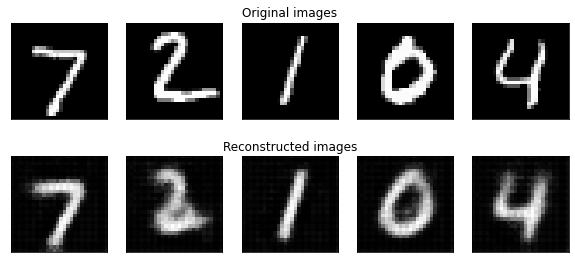

	 partial train loss (single batch): 8995.510742
	 partial train loss (single batch): 9113.604492
	 partial train loss (single batch): 9506.958008
	 partial train loss (single batch): 9112.645508
	 partial train loss (single batch): 9150.638672
	 partial train loss (single batch): 8943.713867
	 partial train loss (single batch): 9149.914062
	 partial train loss (single batch): 9026.941406
	 partial train loss (single batch): 9294.170898
	 partial train loss (single batch): 9097.453125
	 partial train loss (single batch): 8777.394531
	 partial train loss (single batch): 9201.590820
	 partial train loss (single batch): 9051.556641
	 partial train loss (single batch): 8999.006836
	 partial train loss (single batch): 9417.800781
	 partial train loss (single batch): 9033.410156
	 partial train loss (single batch): 9078.560547
	 partial train loss (single batch): 9220.776367
	 partial train loss (single batch): 8926.300781
	 partial train loss (single batch): 8872.092773
	 partial train loss

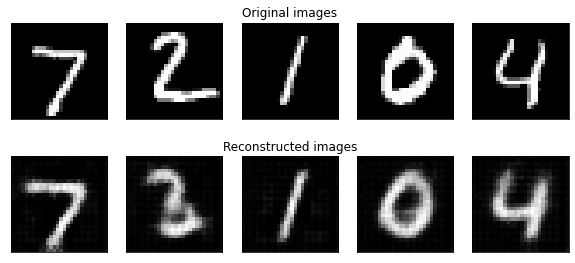

	 partial train loss (single batch): 8868.162109
	 partial train loss (single batch): 8958.800781
	 partial train loss (single batch): 9416.285156
	 partial train loss (single batch): 8883.986328
	 partial train loss (single batch): 8968.401367
	 partial train loss (single batch): 8813.443359
	 partial train loss (single batch): 8905.625977
	 partial train loss (single batch): 8871.361328
	 partial train loss (single batch): 9129.298828
	 partial train loss (single batch): 8965.017578
	 partial train loss (single batch): 8559.382812
	 partial train loss (single batch): 9050.920898
	 partial train loss (single batch): 9055.305664
	 partial train loss (single batch): 8866.298828
	 partial train loss (single batch): 9309.580078
	 partial train loss (single batch): 8906.398438
	 partial train loss (single batch): 8993.079102
	 partial train loss (single batch): 9117.300781
	 partial train loss (single batch): 8784.617188
	 partial train loss (single batch): 8766.483398
	 partial train loss

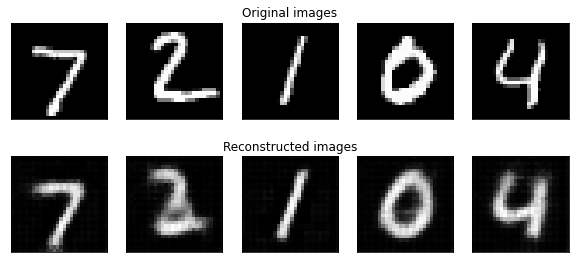

	 partial train loss (single batch): 8820.244141
	 partial train loss (single batch): 8831.419922
	 partial train loss (single batch): 9262.436523
	 partial train loss (single batch): 8829.518555
	 partial train loss (single batch): 8841.396484
	 partial train loss (single batch): 8737.351562
	 partial train loss (single batch): 8889.080078
	 partial train loss (single batch): 8775.335938
	 partial train loss (single batch): 9053.411133
	 partial train loss (single batch): 8990.589844
	 partial train loss (single batch): 8493.439453
	 partial train loss (single batch): 8924.536133
	 partial train loss (single batch): 8835.157227
	 partial train loss (single batch): 8707.669922
	 partial train loss (single batch): 9123.842773
	 partial train loss (single batch): 8821.306641
	 partial train loss (single batch): 8938.249023
	 partial train loss (single batch): 9000.509766
	 partial train loss (single batch): 8660.306641
	 partial train loss (single batch): 8682.852539
	 partial train loss

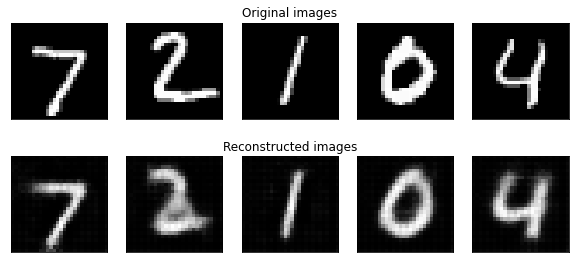

	 partial train loss (single batch): 8724.101562
	 partial train loss (single batch): 8781.298828
	 partial train loss (single batch): 9156.318359
	 partial train loss (single batch): 8693.175781
	 partial train loss (single batch): 8728.126953
	 partial train loss (single batch): 8655.519531
	 partial train loss (single batch): 8741.406250
	 partial train loss (single batch): 8680.981445
	 partial train loss (single batch): 8992.762695
	 partial train loss (single batch): 8869.096680
	 partial train loss (single batch): 8396.103516
	 partial train loss (single batch): 8834.029297
	 partial train loss (single batch): 8872.380859
	 partial train loss (single batch): 8656.666992
	 partial train loss (single batch): 9084.293945
	 partial train loss (single batch): 8663.689453
	 partial train loss (single batch): 8808.535156
	 partial train loss (single batch): 8935.099609
	 partial train loss (single batch): 8620.721680
	 partial train loss (single batch): 8563.860352
	 partial train loss

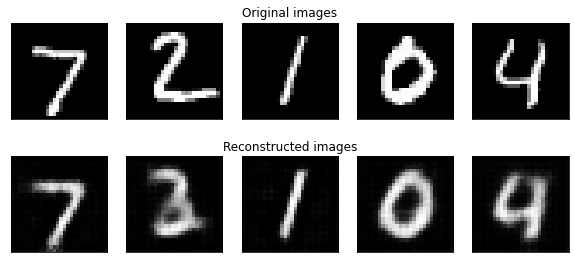

	 partial train loss (single batch): 8542.150391
	 partial train loss (single batch): 8710.184570
	 partial train loss (single batch): 9191.059570
	 partial train loss (single batch): 8760.345703
	 partial train loss (single batch): 8823.919922
	 partial train loss (single batch): 8591.453125
	 partial train loss (single batch): 8808.007812
	 partial train loss (single batch): 8660.365234
	 partial train loss (single batch): 8955.162109
	 partial train loss (single batch): 8822.791016
	 partial train loss (single batch): 8448.316406
	 partial train loss (single batch): 8756.553711
	 partial train loss (single batch): 8753.188477
	 partial train loss (single batch): 8698.969727
	 partial train loss (single batch): 9009.163086
	 partial train loss (single batch): 8634.319336
	 partial train loss (single batch): 8774.186523
	 partial train loss (single batch): 8864.291016
	 partial train loss (single batch): 8468.210938
	 partial train loss (single batch): 8524.191406
	 partial train loss

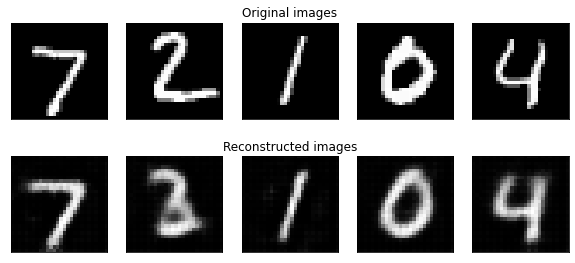

	 partial train loss (single batch): 8626.501953
	 partial train loss (single batch): 8738.171875
	 partial train loss (single batch): 8994.641602
	 partial train loss (single batch): 8674.865234
	 partial train loss (single batch): 8703.498047
	 partial train loss (single batch): 8602.187500
	 partial train loss (single batch): 8755.477539
	 partial train loss (single batch): 8584.644531
	 partial train loss (single batch): 8906.666016
	 partial train loss (single batch): 8763.785156
	 partial train loss (single batch): 8385.785156
	 partial train loss (single batch): 8800.866211
	 partial train loss (single batch): 8700.184570
	 partial train loss (single batch): 8619.312500
	 partial train loss (single batch): 8980.291016
	 partial train loss (single batch): 8576.216797
	 partial train loss (single batch): 8714.695312
	 partial train loss (single batch): 8858.011719
	 partial train loss (single batch): 8510.802734
	 partial train loss (single batch): 8479.550781
	 partial train loss

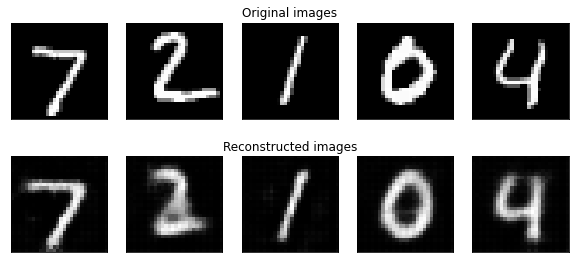

	 partial train loss (single batch): 8550.115234
	 partial train loss (single batch): 8689.255859
	 partial train loss (single batch): 9024.628906
	 partial train loss (single batch): 8593.070312
	 partial train loss (single batch): 8656.890625
	 partial train loss (single batch): 8484.280273
	 partial train loss (single batch): 8696.863281
	 partial train loss (single batch): 8479.061523
	 partial train loss (single batch): 8832.877930
	 partial train loss (single batch): 8677.744141
	 partial train loss (single batch): 8295.865234
	 partial train loss (single batch): 8645.751953
	 partial train loss (single batch): 8702.771484
	 partial train loss (single batch): 8497.431641
	 partial train loss (single batch): 8947.240234
	 partial train loss (single batch): 8587.148438
	 partial train loss (single batch): 8663.361328
	 partial train loss (single batch): 8768.428711
	 partial train loss (single batch): 8484.774414
	 partial train loss (single batch): 8453.546875
	 partial train loss

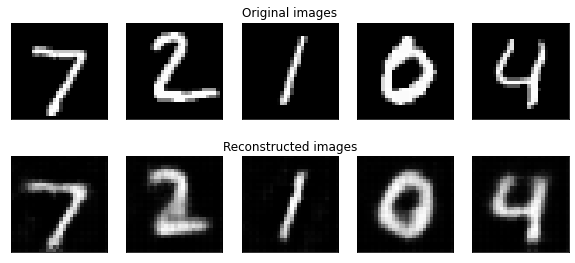

	 partial train loss (single batch): 8483.750977
	 partial train loss (single batch): 8556.186523
	 partial train loss (single batch): 8942.270508
	 partial train loss (single batch): 8643.997070
	 partial train loss (single batch): 8608.849609
	 partial train loss (single batch): 8514.697266
	 partial train loss (single batch): 8615.771484
	 partial train loss (single batch): 8512.410156
	 partial train loss (single batch): 8873.171875
	 partial train loss (single batch): 8664.275391
	 partial train loss (single batch): 8273.507812
	 partial train loss (single batch): 8638.753906
	 partial train loss (single batch): 8680.366211
	 partial train loss (single batch): 8598.215820
	 partial train loss (single batch): 8874.899414
	 partial train loss (single batch): 8633.281250
	 partial train loss (single batch): 8598.560547
	 partial train loss (single batch): 8770.400391
	 partial train loss (single batch): 8377.894531
	 partial train loss (single batch): 8380.799805
	 partial train loss

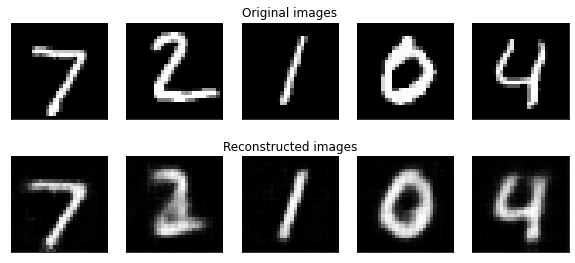

	 partial train loss (single batch): 8517.919922
	 partial train loss (single batch): 8500.988281
	 partial train loss (single batch): 8960.175781
	 partial train loss (single batch): 8576.316406
	 partial train loss (single batch): 8527.064453
	 partial train loss (single batch): 8440.793945
	 partial train loss (single batch): 8570.564453
	 partial train loss (single batch): 8520.506836
	 partial train loss (single batch): 8732.452148
	 partial train loss (single batch): 8600.308594
	 partial train loss (single batch): 8249.954102
	 partial train loss (single batch): 8604.693359
	 partial train loss (single batch): 8623.201172
	 partial train loss (single batch): 8524.406250
	 partial train loss (single batch): 8847.350586
	 partial train loss (single batch): 8449.770508
	 partial train loss (single batch): 8561.717773
	 partial train loss (single batch): 8777.995117
	 partial train loss (single batch): 8461.913086
	 partial train loss (single batch): 8342.107422
	 partial train loss

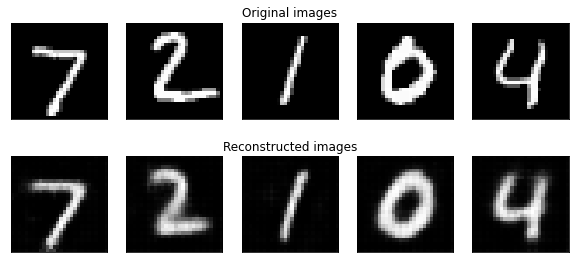

	 partial train loss (single batch): 8413.357422
	 partial train loss (single batch): 8548.703125
	 partial train loss (single batch): 8898.804688
	 partial train loss (single batch): 8548.003906
	 partial train loss (single batch): 8529.328125
	 partial train loss (single batch): 8471.571289
	 partial train loss (single batch): 8593.380859
	 partial train loss (single batch): 8460.842773
	 partial train loss (single batch): 8735.161133
	 partial train loss (single batch): 8590.705078
	 partial train loss (single batch): 8186.875977
	 partial train loss (single batch): 8576.615234
	 partial train loss (single batch): 8618.025391
	 partial train loss (single batch): 8502.979492
	 partial train loss (single batch): 8843.108398
	 partial train loss (single batch): 8450.403320
	 partial train loss (single batch): 8511.137695
	 partial train loss (single batch): 8782.164062
	 partial train loss (single batch): 8335.908203
	 partial train loss (single batch): 8358.113281
	 partial train loss

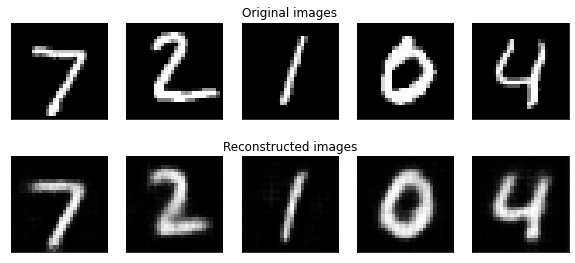

	 partial train loss (single batch): 8407.547852
	 partial train loss (single batch): 8446.845703
	 partial train loss (single batch): 8850.073242
	 partial train loss (single batch): 8517.564453
	 partial train loss (single batch): 8447.097656
	 partial train loss (single batch): 8339.914062
	 partial train loss (single batch): 8430.981445
	 partial train loss (single batch): 8459.068359
	 partial train loss (single batch): 8654.417969
	 partial train loss (single batch): 8467.573242
	 partial train loss (single batch): 8152.923828
	 partial train loss (single batch): 8476.883789
	 partial train loss (single batch): 8561.664062
	 partial train loss (single batch): 8432.092773
	 partial train loss (single batch): 8812.571289
	 partial train loss (single batch): 8403.527344
	 partial train loss (single batch): 8489.480469
	 partial train loss (single batch): 8683.751953
	 partial train loss (single batch): 8278.789062
	 partial train loss (single batch): 8320.689453
	 partial train loss

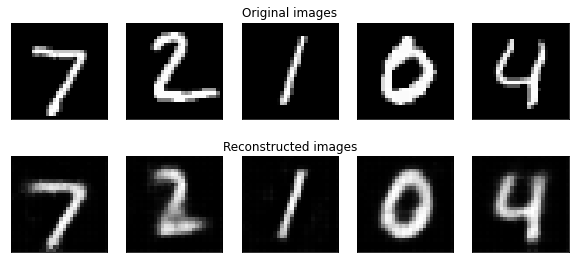

	 partial train loss (single batch): 8391.537109
	 partial train loss (single batch): 8347.744141
	 partial train loss (single batch): 8818.076172
	 partial train loss (single batch): 8414.181641
	 partial train loss (single batch): 8517.089844
	 partial train loss (single batch): 8301.015625
	 partial train loss (single batch): 8628.934570
	 partial train loss (single batch): 8439.648438
	 partial train loss (single batch): 8664.541992
	 partial train loss (single batch): 8512.896484
	 partial train loss (single batch): 8154.430176
	 partial train loss (single batch): 8495.052734
	 partial train loss (single batch): 8542.876953
	 partial train loss (single batch): 8399.615234
	 partial train loss (single batch): 8800.802734
	 partial train loss (single batch): 8384.843750
	 partial train loss (single batch): 8489.244141
	 partial train loss (single batch): 8590.796875
	 partial train loss (single batch): 8275.498047
	 partial train loss (single batch): 8274.021484
	 partial train loss

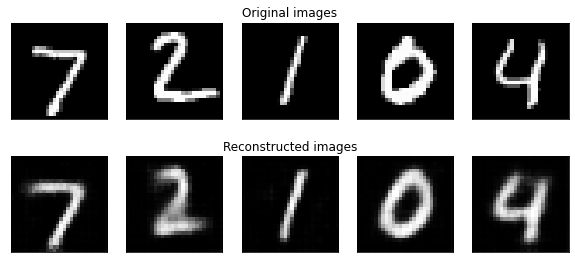

	 partial train loss (single batch): 8327.383789
	 partial train loss (single batch): 8349.759766
	 partial train loss (single batch): 8808.849609
	 partial train loss (single batch): 8495.958008
	 partial train loss (single batch): 8573.758789
	 partial train loss (single batch): 8421.098633
	 partial train loss (single batch): 8472.265625
	 partial train loss (single batch): 8362.103516
	 partial train loss (single batch): 8674.946289
	 partial train loss (single batch): 8499.254883
	 partial train loss (single batch): 8222.646484
	 partial train loss (single batch): 8611.613281
	 partial train loss (single batch): 8600.787109
	 partial train loss (single batch): 8357.906250
	 partial train loss (single batch): 8776.384766
	 partial train loss (single batch): 8342.331055
	 partial train loss (single batch): 8533.071289
	 partial train loss (single batch): 8652.719727
	 partial train loss (single batch): 8262.837891
	 partial train loss (single batch): 8246.412109
	 partial train loss

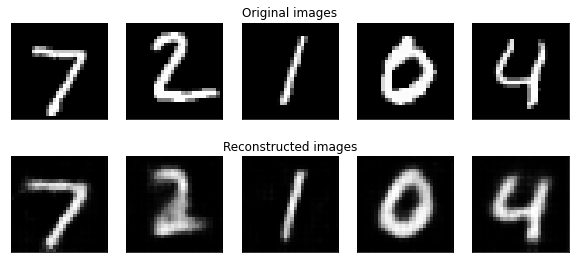

	 partial train loss (single batch): 8285.082031
	 partial train loss (single batch): 8377.311523
	 partial train loss (single batch): 8786.973633
	 partial train loss (single batch): 8486.126953
	 partial train loss (single batch): 8416.638672
	 partial train loss (single batch): 8315.715820
	 partial train loss (single batch): 8532.682617
	 partial train loss (single batch): 8240.906250
	 partial train loss (single batch): 8704.837891
	 partial train loss (single batch): 8473.524414
	 partial train loss (single batch): 8123.256836
	 partial train loss (single batch): 8469.499023
	 partial train loss (single batch): 8420.080078
	 partial train loss (single batch): 8351.863281
	 partial train loss (single batch): 8753.722656
	 partial train loss (single batch): 8300.628906
	 partial train loss (single batch): 8346.876953
	 partial train loss (single batch): 8713.560547
	 partial train loss (single batch): 8291.457031
	 partial train loss (single batch): 8217.445312
	 partial train loss

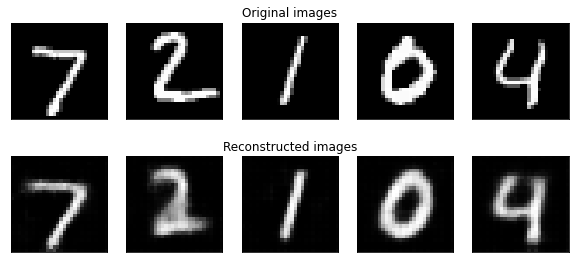

	 partial train loss (single batch): 8365.355469
	 partial train loss (single batch): 8391.314453
	 partial train loss (single batch): 8747.404297
	 partial train loss (single batch): 8497.458008
	 partial train loss (single batch): 8432.394531
	 partial train loss (single batch): 8317.967773
	 partial train loss (single batch): 8511.484375
	 partial train loss (single batch): 8343.647461
	 partial train loss (single batch): 8566.581055
	 partial train loss (single batch): 8471.322266
	 partial train loss (single batch): 8169.362305
	 partial train loss (single batch): 8497.947266
	 partial train loss (single batch): 8471.098633
	 partial train loss (single batch): 8329.571289
	 partial train loss (single batch): 8722.503906
	 partial train loss (single batch): 8302.625000
	 partial train loss (single batch): 8385.208008
	 partial train loss (single batch): 8599.944336
	 partial train loss (single batch): 8247.610352
	 partial train loss (single batch): 8135.720703
	 partial train loss

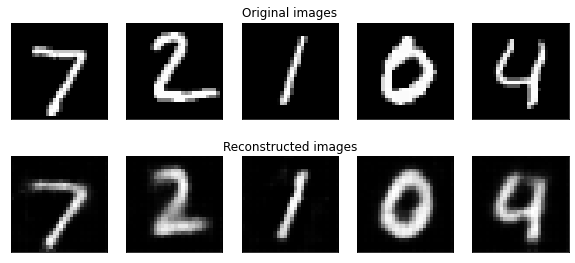

	 partial train loss (single batch): 8290.226562
	 partial train loss (single batch): 8388.050781
	 partial train loss (single batch): 8742.441406
	 partial train loss (single batch): 8496.947266
	 partial train loss (single batch): 8422.485352
	 partial train loss (single batch): 8261.531250
	 partial train loss (single batch): 8508.152344
	 partial train loss (single batch): 8297.431641
	 partial train loss (single batch): 8626.125977
	 partial train loss (single batch): 8408.957031
	 partial train loss (single batch): 8139.577148
	 partial train loss (single batch): 8410.205078
	 partial train loss (single batch): 8415.158203
	 partial train loss (single batch): 8275.505859
	 partial train loss (single batch): 8637.322266
	 partial train loss (single batch): 8398.081055
	 partial train loss (single batch): 8404.594727
	 partial train loss (single batch): 8642.749023
	 partial train loss (single batch): 8234.050781
	 partial train loss (single batch): 8276.366211
	 partial train loss

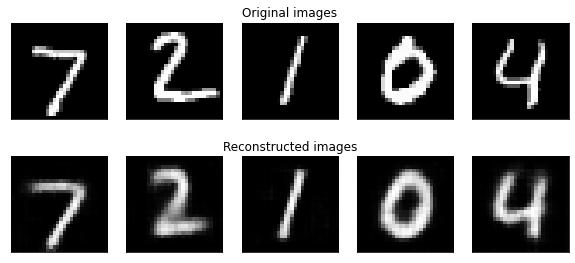

	 partial train loss (single batch): 8284.320312
	 partial train loss (single batch): 8236.041016
	 partial train loss (single batch): 8835.228516
	 partial train loss (single batch): 8438.482422
	 partial train loss (single batch): 8368.884766
	 partial train loss (single batch): 8211.181641
	 partial train loss (single batch): 8466.761719
	 partial train loss (single batch): 8302.864258
	 partial train loss (single batch): 8603.626953
	 partial train loss (single batch): 8442.970703
	 partial train loss (single batch): 8075.032715
	 partial train loss (single batch): 8472.534180
	 partial train loss (single batch): 8468.310547
	 partial train loss (single batch): 8297.995117
	 partial train loss (single batch): 8691.614258
	 partial train loss (single batch): 8302.158203
	 partial train loss (single batch): 8424.067383
	 partial train loss (single batch): 8588.100586
	 partial train loss (single batch): 8203.081055
	 partial train loss (single batch): 8151.288574
	 partial train loss

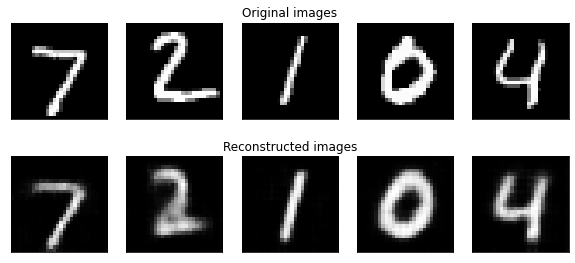

	 partial train loss (single batch): 8300.951172
	 partial train loss (single batch): 8279.686523
	 partial train loss (single batch): 8779.110352
	 partial train loss (single batch): 8490.689453
	 partial train loss (single batch): 8402.966797
	 partial train loss (single batch): 8280.701172
	 partial train loss (single batch): 8409.886719
	 partial train loss (single batch): 8277.781250
	 partial train loss (single batch): 8546.721680
	 partial train loss (single batch): 8318.005859
	 partial train loss (single batch): 8059.153809
	 partial train loss (single batch): 8406.056641
	 partial train loss (single batch): 8470.410156
	 partial train loss (single batch): 8325.664062
	 partial train loss (single batch): 8725.798828
	 partial train loss (single batch): 8303.419922
	 partial train loss (single batch): 8383.961914
	 partial train loss (single batch): 8534.453125
	 partial train loss (single batch): 8187.165039
	 partial train loss (single batch): 8068.686523
	 partial train loss

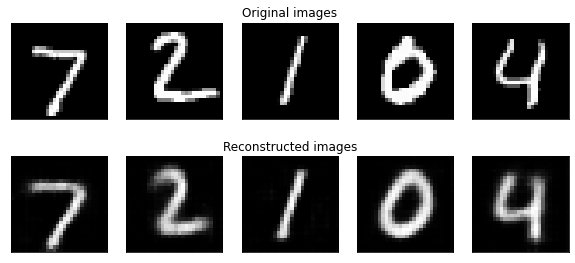

	 partial train loss (single batch): 8271.367188
	 partial train loss (single batch): 8303.871094
	 partial train loss (single batch): 8689.427734
	 partial train loss (single batch): 8364.705078
	 partial train loss (single batch): 8430.742188
	 partial train loss (single batch): 8209.264648
	 partial train loss (single batch): 8388.041016
	 partial train loss (single batch): 8295.691406
	 partial train loss (single batch): 8498.662109
	 partial train loss (single batch): 8353.406250
	 partial train loss (single batch): 8042.471680
	 partial train loss (single batch): 8390.359375
	 partial train loss (single batch): 8360.033203
	 partial train loss (single batch): 8347.605469
	 partial train loss (single batch): 8716.623047
	 partial train loss (single batch): 8178.321289
	 partial train loss (single batch): 8381.925781
	 partial train loss (single batch): 8544.405273
	 partial train loss (single batch): 8202.277344
	 partial train loss (single batch): 8102.043945
	 partial train loss

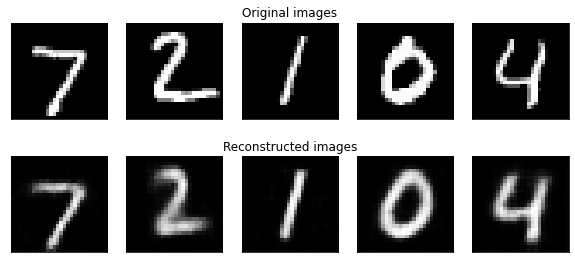

In [31]:
num_epochs = 25
for epoch in range(num_epochs):

   train_loss = train_epoch(vae,device,train_loader,optim)
   val_loss = test_epoch(vae,device,valid_loader)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

   plot_ae_outputs(vae.encoder,vae.decoder,n=5)

## 4.Generate samples

In [32]:
def plot_reconstructed(decoder, r0=(-5, 10), r1=(-10, 5), n=10):
    plt.figure(figsize=(20,8.5))
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1], cmap='gist_gray')

In [33]:
plot_reconstructed(vae.decoder, r0=(-2, 2), r1=(-2, 2))

RuntimeError: ignored

<Figure size 1440x612 with 0 Axes>

## 5.Visualize latent space

In [34]:
encoded_samples = []
for sample in tqdm(test_dataset):
    img = sample[0].unsqueeze(0).to(device)
    label = sample[1]
    # Encode image
    vae.eval()
    with torch.no_grad():
        encoded_img  = vae.encoder(img)
    # Append to list
    encoded_img = encoded_img.flatten().cpu().numpy()
    encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
    encoded_sample['label'] = label
    encoded_samples.append(encoded_sample)

100%|██████████| 10000/10000 [00:13<00:00, 717.64it/s]


In [35]:
encoded_samples = pd.DataFrame(encoded_samples)
encoded_samples

,Enc. Variable 0,Enc. Variable 1,Enc. Variable 2,Enc. Variable 3,label
0,1.347967,1.472018,0.220375,0.184702,7
1,0.599274,-1.391009,0.032835,0.604339,2
2,1.540190,-0.046028,-0.774523,0.223722,1
3,-0.785390,0.446590,-0.034070,-0.693810,0
4,-0.606661,0.718212,-0.536713,-0.149100,4
...,...,...,...,...,...
9995,0.338481,-1.753368,0.698036,-0.218758,2
9996,-0.571204,-1.081212,0.002742,0.469127,3
9997,0.434847,0.509859,-0.655544,-0.375973,4
9998,0.311753,-0.088874,-0.316026,-0.904624,5


In [2]:
from sklearn.manifold import TSNE
import plotly.express as px

In [43]:
px.scatter(encoded_samples, x='Enc. Variable 0', y='Enc. Variable 1', color=encoded_samples.label.astype(str), opacity=0.7)

In [38]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [39]:
fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
fig.show()

In [40]:
tsne = TSNE(n_components=3)
tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning:

The default initialization in TSNE will change from 'random' to 'pca' in 1.2.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.



In [1]:
fig = px.scatter_3d(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-3d-one', '1': 'tsne-3d-two', '2': 'tsne-3d-three'})
fig.show()

NameError: ignored